# Analysis of qPCR results, measuring fungal root colonization 

In [6]:
import pandas as pd
import os
import seaborn as sb
import matplotlib.pyplot as plt
import math
from Bio import SeqIO
from scipy import stats
from rpy2.robjects import Formula, pandas2ri, r
from rpy2.robjects.pandas2ri import py2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
import rpy2.rinterface
pandas2ri.activate()

%reload_ext rpy2.ipython

## Parsing

In [9]:
def getFullName(df, col):
    mapping=pd.read_csv('mapping.csv',header=None).set_index(0)[1].to_dict()
    mapping={'F'+a:mapping[a] for a in mapping}
    mapping['MOCK']='.MOCK'
    df[col+'_renamed']=df[col].map(mapping)
    df=df.drop(columns=col).rename(index=str,columns={col+'_renamed':col})
    return df

def parseTable(folder):
    #Open file
    df=pd.read_csv(folder+'/'+[a for a in os.listdir(folder) if 'Quantification Cq Results_0.csv' in a][0], sep=';',decimal=',')
    df=df.drop(columns=['Unnamed: 0','Content','Biological Set Name','Cq Std. Dev','Starting Quantity (SQ)','Log Starting Quantity','SQ Mean','SQ Std. Dev','Set Point','Well Note'])
    for i in df.index:
        if df.loc[i,'Well'][0] in ['A','B','E','F']: #two samples per plate column: AB and EF with ITS1 primers
            df.loc[i,'Target']='ITS1'
        else: # others: 
            df.loc[i,'Target']='UBQ10'
    
        if df.loc[i,'Well'][0] in ['A','B','C','D']:
            df.loc[i,'Sample']=int(df.loc[i,'Well'][1:])
        else:
            df.loc[i,'Sample']=int(df.loc[i,'Well'][1:])+12
    df=df.merge(pd.read_csv(folder+'/plate.csv'), on='Sample')
    return df.sort_values(by=['Treatment','Condition'])

def calculateIndex(df):
    values={}
    ratios={}
    for i in set(df['Sample']):
        ubq10=df[(df['Sample']==i) & (df['Target']=='UBQ10')]['Cq'].mean()
        its1=df[(df['Sample']==i) & (df['Target']=='ITS1')]['Cq'].mean()
        ratios[i]=its1/ubq10
        values[i]=2**(-(ratios[i]-ratios[1.0]))
    df['Value']=df['Sample'].map(values)
    return df

In [10]:
DFs=[]
for f in os.listdir('./'):
    if 'qPCR_' in f:
        DFs.append(calculateIndex(parseTable('./'+f)))
        DFs[-1]['qPCR']=f
df=pd.concat(DFs).sort_values(by=['qPCR','Sample'])
df=df[df['Treatment']!='F131'] # fungus 131 was dropped from total study because of contamination

In [11]:
hiP=df[(df['Condition']=='highP')][['Treatment','Sample_ref','Condition','Value']].drop_duplicates()
getFullName(hiP, 'Treatment')
loP=df[(df['Condition']=='lowP')][['Treatment','Sample_ref','Condition','Value']].drop_duplicates()
getFullName(loP, 'Treatment')

,Sample_ref,Condition,Value,Treatment
0,3B1,lowP,1.000000,Verticillium_dahliae_MPI-CAGE-AT-0001
4,4B1,lowP,0.931631,Chaetomium_megalocarpum_MPI-CAGE-AT-0009
12,14B1,lowP,0.893212,Oliveonia_pauxilla_MPI-PUGE-AT-0066
20,15B1,lowP,1.061352,Fusarium_tricinctum_MPI-SDFR-AT-0068
28,16B1,lowP,0.956127,Truncatella_angustata_MPI-SDFR-AT-0073
32,8B1,lowP,0.954570,Ilyonectria_europaea_MPI-CAGE-AT-0026
40,6B1,lowP,1.002874,Dactylonectria_estremocensis_MPI-CAGE-AT-0021
48,5B1,lowP,1.046728,Plectosphaerella_cucumerina_MPI-CAGE-AT-0016
60,17B1,lowP,0.880379,Macrophomina_phaseolina_MPI-SDFR-AT-0080
68,18B1,lowP,0.854367,Sordaria_humana_MPI-SDFR-AT-0083


## Statistics

#### At low Pi

In [17]:
%%R -i loP -o lab -o names
library(multcompView)

loP$Treatment <- as.factor(loP$Treatment)
lm<-lm(Value~Treatment,data=loP)
anova <- aov(lm)
print(summary(anova))

TUKEY <- TukeyHSD(anova, conf.level=0.95)

# group the treatments that are not different each other together.
generate_label_df <- function(TUKEY, variable){
     # Extract labels and factor levels from Tukey post-hoc 
     Tukey.levels <- (TUKEY[[variable]][,4])
     Tukey.labels <- data.frame(multcompLetters(Tukey.levels)['Letters'])
     return(Tukey.labels)
     }
 
# Apply the function on my dataset
LABELS <- generate_label_df(TUKEY , 'Treatment')
lab <- as.vector(LABELS$Letters)
names <- rownames(LABELS)

            Df Sum Sq  Mean Sq F value Pr(>F)    
Treatment   41 0.8096 0.019747   15.61 <2e-16 ***
Residuals   86 0.1088 0.001265                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [13]:
loP['group']=loP['Treatment'].map({names[i]:lab[i] for i in range(len(lab))})

#### At high Pi

In [14]:
%%R -i hiP -o lab -o names
library(multcompView)

hiP$Treatment <- as.factor(hiP$Treatment)
lm<-lm(Value~Treatment,data=hiP)
anova <- aov(lm)
print(summary(anova))

TUKEY <- TukeyHSD(anova, conf.level=0.95)

# group the treatments that are not different each other together.
generate_label_df <- function(TUKEY, variable){
     # Extract labels and factor levels from Tukey post-hoc 
     Tukey.levels <- (TUKEY[[variable]][,4])
     Tukey.labels <- data.frame(multcompLetters(Tukey.levels)['Letters'])
     return(Tukey.labels)
     }
 
# Apply the function on my dataset
LABELS <- generate_label_df(TUKEY , 'Treatment')
lab <- as.vector(LABELS$Letters)
names <- rownames(LABELS)

            Df Sum Sq  Mean Sq F value Pr(>F)    
Treatment   40 0.7175 0.017938   9.707 <2e-16 ***
Residuals   85 0.1571 0.001848                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
1 observation deleted due to missingness


In [15]:
hiP['group']=hiP['Treatment'].map({names[i]:lab[i] for i in range(len(lab))})

## Plot results

(0.67, 1.21)

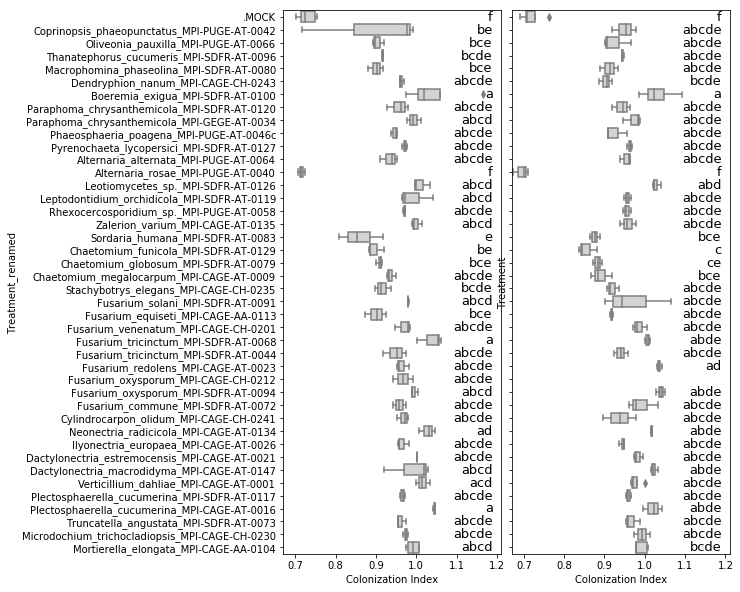

In [18]:
order=['.MOCK','Coprinopsis_phaeopunctatus_MPI-PUGE-AT-0042','Oliveonia_pauxilla_MPI-PUGE-AT-0066','Thanatephorus_cucumeris_MPI-SDFR-AT-0096','Macrophomina_phaseolina_MPI-SDFR-AT-0080','Dendryphion_nanum_MPI-CAGE-CH-0243','Boeremia_exigua_MPI-SDFR-AT-0100','Paraphoma_chrysanthemicola_MPI-SDFR-AT-0120','Paraphoma_chrysanthemicola_MPI-GEGE-AT-0034','Phaeosphaeria_poagena_MPI-PUGE-AT-0046c','Pyrenochaeta_lycopersici_MPI-SDFR-AT-0127','Alternaria_alternata_MPI-PUGE-AT-0064','Alternaria_rosae_MPI-PUGE-AT-0040','Leotiomycetes_sp._MPI-SDFR-AT-0126','Leptodontidium_orchidicola_MPI-SDFR-AT-0119','Rhexocercosporidium_sp._MPI-PUGE-AT-0058','Zalerion_varium_MPI-CAGE-AT-0135','Sordaria_humana_MPI-SDFR-AT-0083','Chaetomium_funicola_MPI-SDFR-AT-0129','Chaetomium_globosum_MPI-SDFR-AT-0079','Chaetomium_megalocarpum_MPI-CAGE-AT-0009','Stachybotrys_elegans_MPI-CAGE-CH-0235','Fusarium_solani_MPI-SDFR-AT-0091','Fusarium_equiseti_MPI-CAGE-AA-0113','Fusarium_venenatum_MPI-CAGE-CH-0201','Fusarium_tricinctum_MPI-SDFR-AT-0068','Fusarium_tricinctum_MPI-SDFR-AT-0044','Fusarium_redolens_MPI-CAGE-AT-0023','Fusarium_oxysporum_MPI-CAGE-CH-0212','Fusarium_oxysporum_MPI-SDFR-AT-0094','Fusarium_commune_MPI-SDFR-AT-0072','Cylindrocarpon_olidum_MPI-CAGE-CH-0241','Neonectria_radicicola_MPI-CAGE-AT-0134','Ilyonectria_europaea_MPI-CAGE-AT-0026','Dactylonectria_estremocensis_MPI-CAGE-AT-0021','Dactylonectria_macrodidyma_MPI-CAGE-AT-0147','Verticillium_dahliae_MPI-CAGE-AT-0001','Plectosphaerella_cucumerina_MPI-SDFR-AT-0117','Plectosphaerella_cucumerina_MPI-CAGE-AT-0016','Truncatella_angustata_MPI-SDFR-AT-0073','Microdochium_trichocladiopsis_MPI-CAGE-CH-0230','Mortierella_elongata_MPI-CAGE-AA-0104']
hue_order_loP=sorted([a for a in set(loP['group'])])
hue_order_hiP=sorted([a for a in set(hiP['group'])])
f, axes = plt.subplots(1, 2, figsize=(8,10), sharey=True)
plt.subplots_adjust(wspace=0.05)
sb.boxplot(y='Treatment_renamed',orient='h',order=order, x='Value',dodge=False,data=loP, color='lightgray',ax=axes[0])
sb.boxplot(y='Treatment_renamed',orient='h',order=order, x='Value',dodge=False,data=hiP, color='lightgray',ax=axes[1])
axes[0].set_xlabel('Colonization Index')
axes[1].set_xlabel('Colonization Index')
axes[1].set_ylabel('Treatment')
axes[0].set_xlim(0.7,1.1)
axes[1].set_xlim(0.7,1.1)
for t in set(loP['Treatment_renamed']):
    x=max(loP[loP['Treatment_renamed']==t]['Value'])+0.08
    y=order.index(t)
    axes[0].text(1.19,y,list(loP[loP['Treatment_renamed']==t]['group'])[0],horizontalalignment='right',verticalalignment='center', fontsize=13)
for t in set(hiP['Treatment_renamed']):
    x=max(hiP[hiP['Treatment_renamed']==t]['Value'])+0.08
    y=order.index(t)
    axes[1].text(1.19,y,list(hiP[hiP['Treatment_renamed']==t]['group'])[0],horizontalalignment='right',verticalalignment='center', fontsize=13)
axes[1].set_xlim(0.67,1.21)
axes[0].set_xlim(0.67,1.21)